In [1]:
import os
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import math

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import MobileNetV2

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import string
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
fig = plt.figure(figsize =(10, 7))

<Figure size 1000x700 with 0 Axes>

#### 1. Повнозв'язані нейронні мережі
#### Вирішіть завдання класифікації даних, з якими ви працювали в лабораторній № 1 за допомогою повнозв’язаної нейромережі прямого поширення (fully connected feed-forward network). Результати порівняйте з одержаними раніше. 

In [2]:
# https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023
df = pd.read_csv(r'C:\dick_D\maga\1_kurs\Data-Analysis\1\dataset\creditcard_2023.csv', encoding='unicode_escape')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      568630 non-null  int64  
 1   V1      568630 non-null  float64
 2   V2      568630 non-null  float64
 3   V3      568630 non-null  float64
 4   V4      568630 non-null  float64
 5   V5      568630 non-null  float64
 6   V6      568630 non-null  float64
 7   V7      568630 non-null  float64
 8   V8      568630 non-null  float64
 9   V9      568630 non-null  float64
 10  V10     568630 non-null  float64
 11  V11     568630 non-null  float64
 12  V12     568630 non-null  float64
 13  V13     568630 non-null  float64
 14  V14     568630 non-null  float64
 15  V15     568630 non-null  float64
 16  V16     568630 non-null  float64
 17  V17     568630 non-null  float64
 18  V18     568630 non-null  float64
 19  V19     568630 non-null  float64
 20  V20     568630 non-null  float64
 21  V21     56

#### Обробка та зменшення датасету з першої лаболаторної

In [3]:
# видалення непотрібної колонки
df=df.drop(columns='id')

# діставання фіч в яких кореляція буде більше 0.6
corr_matrix = df.corr()
class_corr = corr_matrix['Class'].drop('Class')
class_corr_abs = class_corr.abs()
corr = 0.6
selected_features = class_corr_abs[class_corr_abs >= corr].index.tolist()
selected_features.append('Class')
df = df[selected_features]

# рівномірне зменшення рандомним чином записів
class_0 = df[df['Class'] == 0]
class_1 = df[df['Class'] == 1]
len_c = 10000
if len(class_0) > len_c:
    class_0 = class_0.sample(n=len_c, random_state=42)
if len(class_1) > len_c:
    class_1 = class_1.sample(n=len_c, random_state=42)
balanced_df = pd.concat([class_0, class_1])
df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# прибирання викидів
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df >= lower_bound) & (df <= upper_bound)].dropna()
df

,V3,V4,V10,V11,V12,V14,Class
0,-0.032631,0.456084,-0.306417,0.885170,-0.781245,-0.745441,1
1,0.096435,-0.903140,0.621254,-0.748071,0.361329,-0.066060,0
2,0.388537,-0.772716,0.361861,-0.997131,0.403704,0.251183,0
3,0.497243,-0.682775,0.889316,-1.248013,0.447700,0.754524,0
4,-0.067848,0.365747,-0.402988,0.083672,-0.350951,-0.603288,1
...,...,...,...,...,...,...,...
19995,-0.341136,0.766461,-0.123128,0.308819,-0.303944,-0.961752,1
19996,0.359912,0.434603,0.337878,-0.281315,-0.458435,0.390224,1
19997,2.276791,0.037525,0.328211,-1.607300,0.799576,0.413217,0
19998,1.346685,-0.519964,0.559298,-0.297928,1.497091,0.570311,0


In [4]:
# нормалізація
columns_to_normalize = df.columns.difference(['Class'])
scaler = MinMaxScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# розділ даних на учбові та тестові
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

In [5]:
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                112       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
1353/1353 [==============================] - 3s 2ms/step - loss: 0.2293 - accuracy: 0.9393 - val_loss: 0.1211 - val_accuracy: 0.9526
Epoch 2/50
1353/1353 [==============================] - 2s 1ms/step - loss: 0.1210 - accuracy: 0.9514 - val_loss: 0.1273 - val_accuracy: 0.9555
Epoch 3/50
1353/1353 [==============================] - 2s 2ms/step - loss: 0.1200 - accuracy: 0.9513 - val_loss: 0.1158 - val_accuracy: 0.9543
Epoch 4/50
1353/1353 [==============================] - 2s 2ms/step - loss: 0.1192 - accuracy: 0.9520 - val_loss: 0.1164 - val_accuracy: 0.9533
Epoch 5/50
1353/1353 [==============================] - 2s 2ms/step - loss: 0.1196 - accuracy: 0.9522 - val_loss: 0.1150 - val_accuracy: 0.9565
Epoch 6/50
1353/1353 [==============================] - 2s 2ms/step - loss: 0.1195 - accuracy: 0.9516 - val_loss: 0.1150 - val_accuracy: 0.9564
Epoch 7/50
1353/1353 [==============================] - 2s 2ms/step - loss: 0.1193 - accuracy: 0.9514 - val_loss: 0.1232 - val_accuracy:

In [7]:
y_pred = model.predict(X_test)
y_pred_class = (y_pred >= 0.5).astype("int32").flatten()
print("Accuracy:", accuracy_score(y_test, y_pred_class))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_class))
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

182/182 [==============================] - 0s 915us/step
Accuracy: 0.9601518026565465
Confusion Matrix:
[[2776   90]
 [ 141 2790]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2866
           1       0.97      0.95      0.96      2931

    accuracy                           0.96      5797
   macro avg       0.96      0.96      0.96      5797
weighted avg       0.96      0.96      0.96      5797



Accuracy: 0.9601518026565465
Confusion Matrix:
[[2776   90]
 [ 141 2790]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2866
           1       0.97      0.95      0.96      2931

    accuracy                           0.96      5797
   macro avg       0.96      0.96      0.96      5797
weighted avg       0.96      0.96      0.96      5797



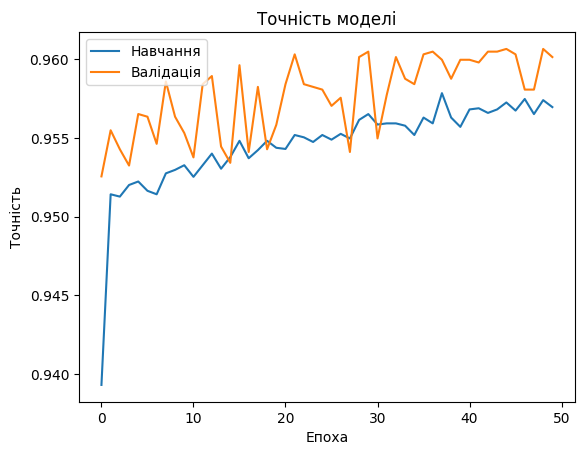

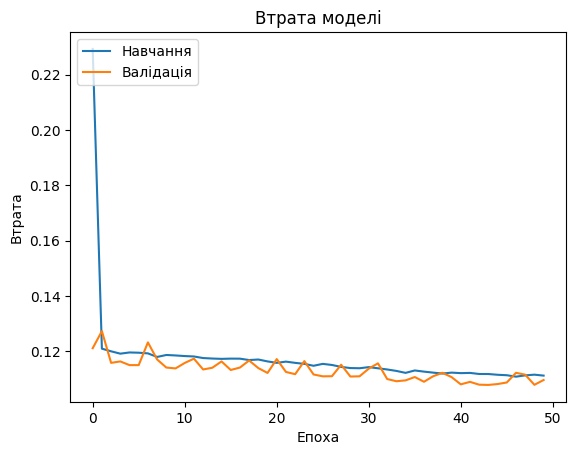

In [8]:
print("Accuracy:", accuracy_score(y_test, y_pred_class))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_class))
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Точність моделі')
plt.ylabel('Точність')
plt.xlabel('Епоха')
plt.legend(['Навчання', 'Валідація'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Втрата моделі')
plt.ylabel('Втрата')
plt.xlabel('Епоха')
plt.legend(['Навчання', 'Валідація'], loc='upper left')
plt.show()

In [9]:
model = Sequential()
model.add(Dense(256, input_shape=X_train.shape[1:], activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               1792      
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 133,633
Trainable params: 133,633
Non-tr

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
1353/1353 [==============================] - 4s 3ms/step - loss: 0.1395 - accuracy: 0.9473 - val_loss: 0.1135 - val_accuracy: 0.9576
Epoch 2/50
1353/1353 [==============================] - 3s 2ms/step - loss: 0.1249 - accuracy: 0.9530 - val_loss: 0.1134 - val_accuracy: 0.9562
Epoch 3/50
1353/1353 [==============================] - 3s 2ms/step - loss: 0.1216 - accuracy: 0.9525 - val_loss: 0.1195 - val_accuracy: 0.9538
Epoch 4/50
1353/1353 [==============================] - 3s 2ms/step - loss: 0.1231 - accuracy: 0.9529 - val_loss: 0.1171 - val_accuracy: 0.9548
Epoch 5/50
1353/1353 [==============================] - 3s 2ms/step - loss: 0.1179 - accuracy: 0.9537 - val_loss: 0.1190 - val_accuracy: 0.9603
Epoch 6/50
1353/1353 [==============================] - 3s 2ms/step - loss: 0.1172 - accuracy: 0.9539 - val_loss: 0.1103 - val_accuracy: 0.9564
Epoch 7/50
1353/1353 [==============================] - 3s 2ms/step - loss: 0.1160 - accuracy: 0.9559 - val_loss: 0.1050 - val_accuracy:

In [11]:
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32").flatten()

print("Accuracy:", accuracy_score(y_test, y_pred_class))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_class))
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

182/182 [==============================] - 0s 1ms/step
Accuracy: 0.9639468690702088
Confusion Matrix:
[[2804   62]
 [ 147 2784]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      2866
           1       0.98      0.95      0.96      2931

    accuracy                           0.96      5797
   macro avg       0.96      0.96      0.96      5797
weighted avg       0.96      0.96      0.96      5797



Accuracy: 0.9639468690702088
Confusion Matrix:
[[2804   62]
 [ 147 2784]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      2866
           1       0.98      0.95      0.96      2931

    accuracy                           0.96      5797
   macro avg       0.96      0.96      0.96      5797
weighted avg       0.96      0.96      0.96      5797



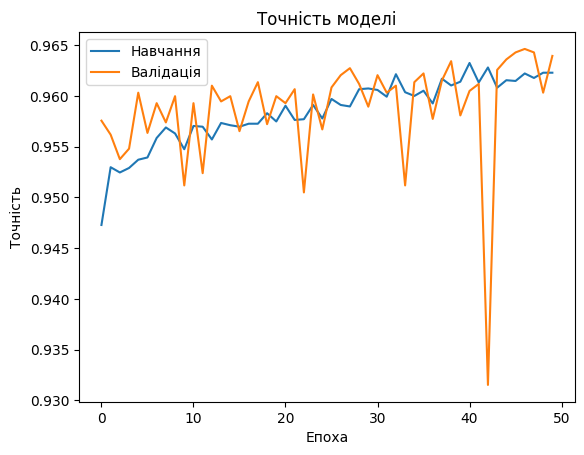

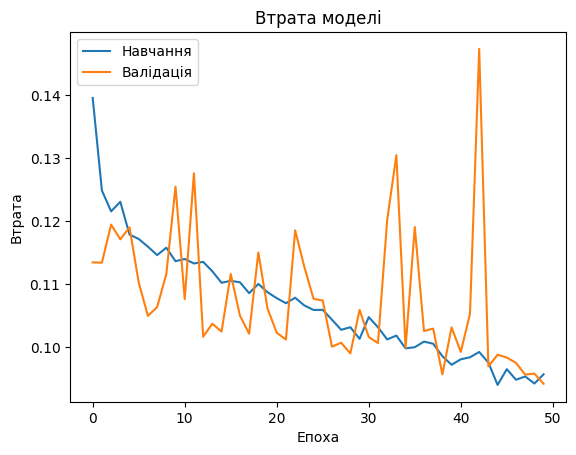

In [12]:
print("Accuracy:", accuracy_score(y_test, y_pred_class))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_class))
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Точність моделі')
plt.ylabel('Точність')
plt.xlabel('Епоха')
plt.legend(['Навчання', 'Валідація'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Втрата моделі')
plt.ylabel('Втрата')
plt.xlabel('Епоха')
plt.legend(['Навчання', 'Валідація'], loc='upper left')
plt.show()

#### Найкращий результат з першої лаболаторної
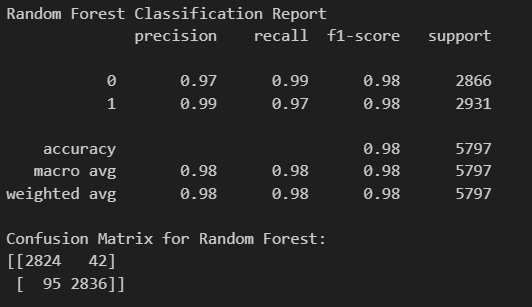

#### 2. Згорткові нейронні мережі
Вирішіть завдання класифікації зображень за допомогою згорткової (convolutional) нейромережі двома способами: 

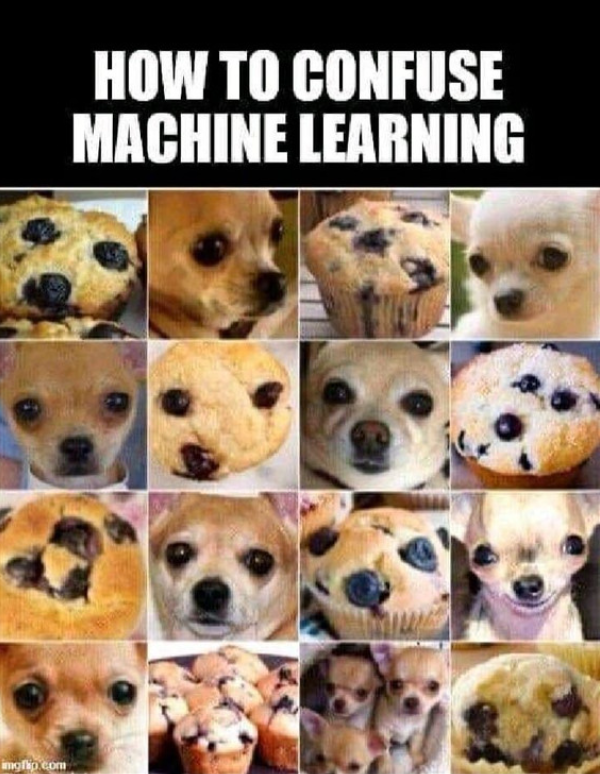

In [13]:
# https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification
train_dir = r'C:\dick_D\maga\1_kurs\Data-Analysis\3\dataset\muffin_chihuahua\train'
test_dir = r'C:\dick_D\maga\1_kurs\Data-Analysis\3\dataset\muffin_chihuahua\test'

In [14]:
# Параметри завантаження
batch_size = 32
img_height = 128
img_width = 128

а) навчить мережу з нуля (from scratch)

In [15]:
# навчальн данні
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',  # Використовуємо цілі числа як мітки
    batch_size=batch_size,
    image_size=(img_height, img_width),  # Автоматично змінюємо розмір зображень
    shuffle=True,
    seed=123
)

# тестові данні
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False
)

# Розділення тестового набору на валідаційний та тестовий
val_batches = tf.data.experimental.cardinality(test_ds) // 2
val_ds = test_ds.take(val_batches)
test_ds = test_ds.skip(val_batches)

Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.


Класи: ['chihuahua', 'muffin']


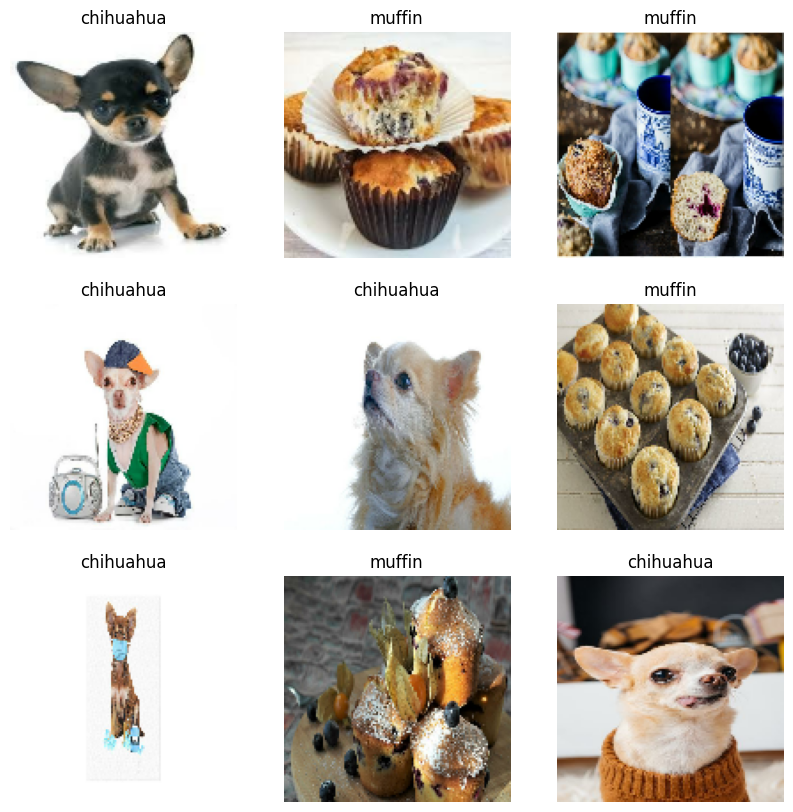

In [16]:
class_names = train_ds.class_names
print("Класи:", class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [17]:
# Нормалізація пікселів до діапазону [0, 1]
normalization_layer = layers.Rescaling(1./255)

# Аугментація даних
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Застосуємо аугментацію та нормалізацію до навчального набору
def preprocess(image, label):
    image = data_augmentation(image)
    image = normalization_layer(image)
    return image, label

In [18]:
# Налаштування буферизації для прискорення завантаження даних
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
model_scratch = keras.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_scratch.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)     

In [20]:
model_scratch.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint(filepath='best_model_scratch.h5', monitor='val_loss', save_best_only=True, mode='min')
history_scratch = model_scratch.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[early_stopping, checkpoint])
model_scratch.load_weights('best_model_scratch.h5')

Epoch 1/30
148/148 [==============================] - 61s 358ms/step - loss: 6.2873 - accuracy: 0.7171 - val_loss: 0.5820 - val_accuracy: 0.7257
Epoch 2/30
148/148 [==============================] - 50s 339ms/step - loss: 0.4719 - accuracy: 0.8132 - val_loss: 0.4612 - val_accuracy: 0.7969
Epoch 3/30
148/148 [==============================] - 45s 307ms/step - loss: 0.3953 - accuracy: 0.8468 - val_loss: 0.9901 - val_accuracy: 0.6233
Epoch 4/30
148/148 [==============================] - 45s 303ms/step - loss: 0.4085 - accuracy: 0.8255 - val_loss: 0.7415 - val_accuracy: 0.6892
Epoch 5/30
148/148 [==============================] - 50s 335ms/step - loss: 0.2744 - accuracy: 0.8939 - val_loss: 0.1674 - val_accuracy: 0.9757
Epoch 6/30
148/148 [==============================] - 53s 357ms/step - loss: 0.1987 - accuracy: 0.9248 - val_loss: 0.4137 - val_accuracy: 0.8264
Epoch 7/30
148/148 [==============================] - 46s 309ms/step - loss: 0.1985 - accuracy: 0.9294 - val_loss: 0.3480 - val_ac

In [21]:
test_loss_scratch, test_acc_scratch = model_scratch.evaluate(test_ds)
print('Точність моделі з нуля на тестовому наборі:', test_acc_scratch)

19/19 [==============================] - 3s 106ms/step - loss: 0.9147 - accuracy: 0.5559
Точність моделі з нуля на тестовому наборі: 0.5559210777282715


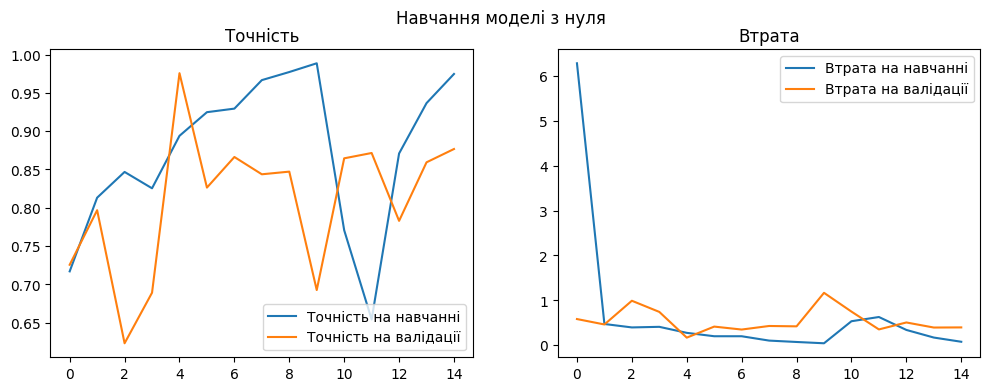

In [22]:
acc = history_scratch.history['accuracy']
val_acc = history_scratch.history['val_accuracy']
loss = history_scratch.history['loss']
val_loss = history_scratch.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.suptitle('Навчання моделі з нуля')

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точність на навчанні')
plt.plot(epochs_range, val_acc, label='Точність на валідації')
plt.legend(loc='lower right')
plt.title('Точність')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Втрата на навчанні')
plt.plot(epochs_range, val_loss, label='Втрата на валідації')
plt.legend(loc='upper right')
plt.title('Втрата')

plt.show()

1/1 [==============================] - 0s 73ms/step
Звіт про класифікацію (модель з нуля):
              precision    recall  f1-score   support

   chihuahua       0.19      0.95      0.31        64
      muffin       0.99      0.51      0.67       544

    accuracy                           0.56       608
   macro avg       0.59      0.73      0.49       608
weighted avg       0.90      0.56      0.63       608



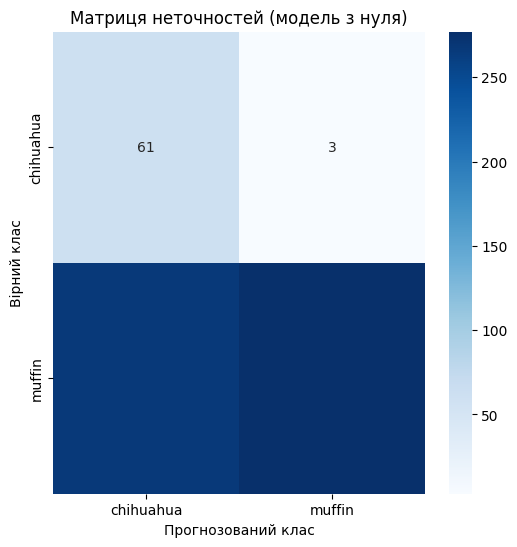

In [23]:
# Отримання прогнозів
def get_predictions(model, dataset):
    y_pred = []
    y_true = []
    for images, labels in dataset:
        preds = model.predict(images)
        y_pred.extend(preds.flatten())
        y_true.extend(labels.numpy())
    y_pred_class = [1 if prob > 0.5 else 0 for prob in y_pred]
    return y_true, y_pred_class

y_true_scratch, y_pred_scratch = get_predictions(model_scratch, test_ds)

# Звіт про класифікацію
print('Звіт про класифікацію (модель з нуля):')
print(classification_report(y_true_scratch, y_pred_scratch, target_names=class_names))

# Матриця неточностей
cm = confusion_matrix(y_true_scratch, y_pred_scratch)
plt.figure(figsize=(6, 6))
plt.title('Матриця неточностей (модель з нуля)')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Прогнозований клас')
plt.ylabel('Вірний клас')
plt.show()


б) застосуйте перенесення навчання (transfer learning from pre-trained weights) 

In [24]:
base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Заморожуємо базову модель

# Побудова повної моделі з перенесенням навчання
model_tl = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_tl.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_9 (Dense)             (None, 128)               163968    
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,422,081
Trainable params: 164,097
Non-trainable params: 2,257,984
_________________________________________________________________


In [25]:
model_tl.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint_initial = keras.callbacks.ModelCheckpoint(
    filepath='best_model_tl_initial.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    save_weights_only=True
)

history_tl = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, checkpoint_initial]
)

model_tl.load_weights('best_model_tl_initial.h5')

Epoch 1/10
148/148 [==============================] - 34s 216ms/step - loss: 0.4337 - accuracy: 0.8008 - val_loss: 0.3067 - val_accuracy: 0.8698
Epoch 2/10
148/148 [==============================] - 31s 211ms/step - loss: 0.3383 - accuracy: 0.8527 - val_loss: 0.3165 - val_accuracy: 0.8663
Epoch 3/10
148/148 [==============================] - 32s 217ms/step - loss: 0.2969 - accuracy: 0.8724 - val_loss: 0.4117 - val_accuracy: 0.8108
Epoch 4/10
148/148 [==============================] - 32s 214ms/step - loss: 0.2783 - accuracy: 0.8832 - val_loss: 0.2273 - val_accuracy: 0.9010
Epoch 5/10
148/148 [==============================] - 32s 218ms/step - loss: 0.2428 - accuracy: 0.9013 - val_loss: 0.2582 - val_accuracy: 0.8958
Epoch 6/10
148/148 [==============================] - 32s 214ms/step - loss: 0.2322 - accuracy: 0.9030 - val_loss: 0.2710 - val_accuracy: 0.8854
Epoch 7/10
148/148 [==============================] - 31s 211ms/step - loss: 0.2164 - accuracy: 0.9070 - val_loss: 0.1451 - val_ac

In [26]:
# Тонке налаштування моделі (розморожуємо деякі шари базової моделі)
base_model.trainable = True
fine_tune_at = 100  # Розморожуємо останні 100 шарів

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Перекомпіляція моделі з меншою швидкістю навчання
model_tl.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# контрольна точка для тонкого налаштування
checkpoint_fine = keras.callbacks.ModelCheckpoint(
    filepath='best_model_tl_finetune.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    save_weights_only=True
)

# Fine-tuning
history_ft = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, checkpoint_fine]
)

model_tl.load_weights('best_model_tl_finetune.h5')

Epoch 1/10
148/148 [==============================] - 58s 355ms/step - loss: 2.5245 - accuracy: 0.6679 - val_loss: 0.4426 - val_accuracy: 0.8542
Epoch 2/10
148/148 [==============================] - 50s 341ms/step - loss: 0.8249 - accuracy: 0.8363 - val_loss: 0.5032 - val_accuracy: 0.8316
Epoch 3/10
148/148 [==============================] - 51s 342ms/step - loss: 0.4140 - accuracy: 0.8956 - val_loss: 0.4411 - val_accuracy: 0.8368
Epoch 4/10
148/148 [==============================] - 51s 344ms/step - loss: 0.2223 - accuracy: 0.9334 - val_loss: 0.4275 - val_accuracy: 0.8351
Epoch 5/10
148/148 [==============================] - 51s 341ms/step - loss: 0.1214 - accuracy: 0.9685 - val_loss: 0.4285 - val_accuracy: 0.8316
Epoch 6/10
148/148 [==============================] - 51s 344ms/step - loss: 0.0707 - accuracy: 0.9852 - val_loss: 0.4476 - val_accuracy: 0.8316
Epoch 7/10
148/148 [==============================] - 52s 353ms/step - loss: 0.0444 - accuracy: 0.9949 - val_loss: 0.4884 - val_ac

19/19 [==============================] - 3s 170ms/step - loss: 0.3565 - accuracy: 0.8799
Точність на тестовому наборі: 0.8799


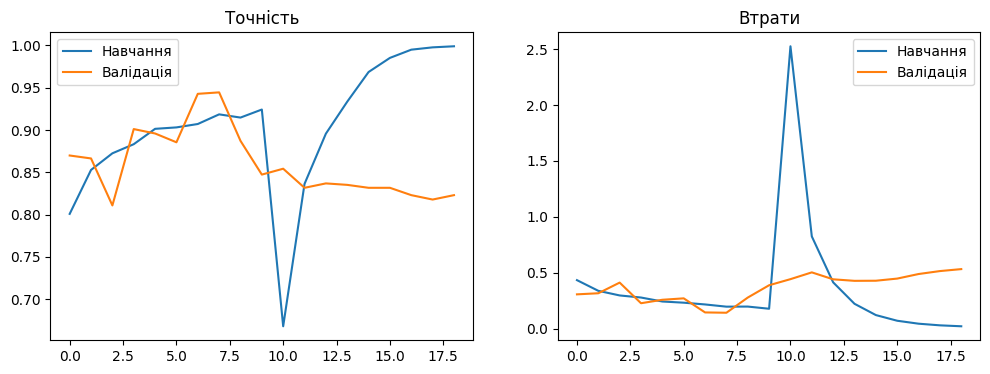

In [27]:
# Оцінка моделі на тестовому наборі
test_loss_tl, test_accuracy_tl = model_tl.evaluate(test_ds)
print(f"Точність на тестовому наборі: {test_accuracy_tl:.4f}")

# Візуалізація точності та втрати під час навчання
def plot_metrics(history, history_ft):
    acc = history.history['accuracy'] + history_ft.history['accuracy']
    val_acc = history.history['val_accuracy'] + history_ft.history['val_accuracy']
    loss = history.history['loss'] + history_ft.history['loss']
    val_loss = history.history['val_loss'] + history_ft.history['val_loss']
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Навчання')
    plt.plot(epochs_range, val_acc, label='Валідація')
    plt.title('Точність')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Навчання')
    plt.plot(epochs_range, val_loss, label='Валідація')
    plt.title('Втрати')
    plt.legend()
    
    plt.show()

plot_metrics(history_tl, history_ft)

1/1 [==============================] - 0s 192ms/step
Звіт про класифікацію:
              precision    recall  f1-score   support

   chihuahua       0.46      0.83      0.59        64
      muffin       0.98      0.89      0.93       544

    accuracy                           0.88       608
   macro avg       0.72      0.86      0.76       608
weighted avg       0.92      0.88      0.89       608



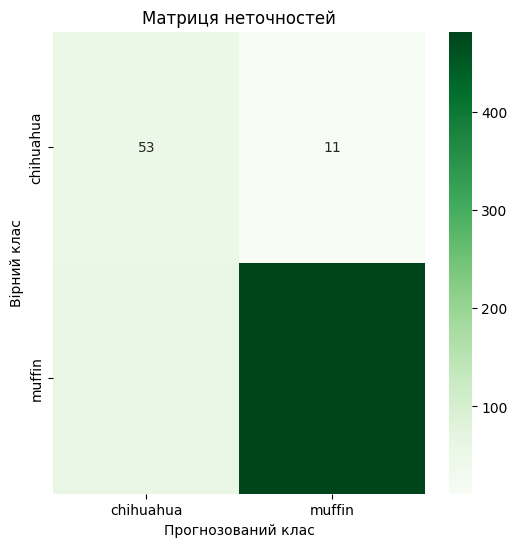

In [28]:
y_true_tl = []
y_pred_tl = []

for images, labels in test_ds:
    preds = model_tl.predict(images)
    y_pred_tl.extend(preds.flatten())
    y_true_tl.extend(labels.numpy())

# Бінаризація прогнозів
y_pred_class_tl = [1 if prob > 0.5 else 0 for prob in y_pred_tl]

# Звіт про класифікацію
print('Звіт про класифікацію:')
print(classification_report(y_true_tl, y_pred_class_tl, target_names=class_names))

# Матриця неточностей
cm = confusion_matrix(y_true_tl, y_pred_class_tl)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Прогнозований клас')
plt.ylabel('Вірний клас')
plt.title('Матриця неточностей')
plt.show()

#### 3. Рекурентні нейронні мережі
Вирішіть задачу класифікації текстів (з якими ви працювали в лабораторній № 2) за допомогою рекурентної нейромережі двома способами:

In [29]:
# https://www.kaggle.com/datasets/thedevastator/sms-spam-collection-a-more-diverse-dataset/data
df = pd.read_csv(r'C:\dick_D\maga\1_kurs\Data-Analysis\2\dataset\sms_spam.csv', encoding='unicode_escape')
df.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [30]:
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

def text_preprocessing(text):
    # Перетворення тексту в нижній регістр
    text = text.lower()
    # Токенізація тексту
    tokens = tokenizer.tokenize(text)
    # Видалення стоп-слів
    tokens = [word for word in tokens if word not in stop_words]
    # Об'єднання токенів назад у рядок
    clean_text = ' '.join(tokens)
    return clean_text
# Застосування функції до колонки 'sms'
df['clean_sms'] = df['sms'].apply(text_preprocessing)
df.head()

,sms,label,clean_sms
0,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...\n,0,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win fa cup final tkts 2...
3,U dun say so early hor... U c already then say...,0,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",0,nah think goes usf lives around though


In [31]:
# Максимальна кількість слів
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['clean_sms'])

# Перетворення текстів у послідовності
sequences = tokenizer.texts_to_sequences(df['clean_sms'])

# Максимальна довжина послідовності
max_seq_len = max(len(seq) for seq in sequences)

# Паддінг послідовностей
padded_sequences = pad_sequences(sequences, maxlen=max_seq_len)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['label'], test_size=0.2, random_state=42)

#### а) навчить мережу і embedding шар з нуля (from scratch)

In [33]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_seq_len))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 78, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [34]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,         
    verbose=1,
    restore_best_weights=True
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    'best_model_text.h5',        
    monitor='val_loss',    
    save_best_only=True,    
    verbose=1
)


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [35]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping, model_checkpoint]
)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
62/63 [============================>.] - ETA: 0s - loss: 0.2574 - accuracy: 0.9239
Epoch 1: val_loss improved from inf to 0.13885, saving model to best_model_text.h5
63/63 [==============================] - 6s 65ms/step - loss: 0.2581 - accuracy: 0.9240 - val_loss: 0.1388 - val_accuracy: 0.9686
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 0.9903
Epoch 2: val_loss improved from 0.13885 to 0.08666, saving model to best_model_text.h5
63/63 [==============================] - 4s 58ms/step - loss: 0.0398 - accuracy: 0.9903 - val_loss: 0.0867 - val_accuracy: 0.9753
Epoch 3/10
62/63 [============================>.] - ETA: 0s - loss: 0.0116 - accuracy: 0.9975
Epoch 3: val_loss improved from 0.08666 to 0.08144, saving model to best_model_text.h5
63/63 [==============================] - 4s 59ms/step - loss: 0.0115 - accuracy: 0.9975 - val_loss: 0.0814 - val_accuracy: 0.9753
Epoch 4/10
62/63 [============================>.] - ETA: 0s - loss: 0.0

#### б) використовуючи pretrained word embeddings

In [36]:
# Завантаження GloVe embeddings
embeddings_index = {}
with open(r'C:\dick_D\maga\1_kurs\Data-Analysis\3\dataset\glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [37]:
# Розмірність embeddings
embedding_dim = 100
word_index = tokenizer.word_index

# Ініціалізація матриці embeddings
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        # Ініціалізація невідомих слів випадковим вектором або нулями
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

In [38]:
model_glove = Sequential()
model_glove.add(Embedding(input_dim=max_words, output_dim=embedding_dim, weights=[embedding_matrix],
                          input_length=max_seq_len, trainable=False))
model_glove.add(LSTM(64))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model_glove.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 78, 100)           1000000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,042,305
Trainable params: 42,305
Non-trainable params: 1,000,000
_________________________________________________________________


In [39]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model_text_embeddings.h5',
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    mode='max'  
)
early_stopping = EarlyStopping(
    monitor='val_accuracy',  
    patience=5,             
    verbose=1,
    mode='max',
    restore_best_weights=True 
)

In [40]:
history_glove = model_glove.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks = [checkpoint, early_stopping]
)

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 0.2664 - accuracy: 0.8986
Epoch 1: val_accuracy improved from -inf to 0.95516, saving model to best_model_text_embeddings.h5
63/63 [==============================] - 4s 43ms/step - loss: 0.2664 - accuracy: 0.8986 - val_loss: 0.1414 - val_accuracy: 0.9552
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.0886 - accuracy: 0.9721
Epoch 2: val_accuracy improved from 0.95516 to 0.96413, saving model to best_model_text_embeddings.h5
63/63 [==============================] - 2s 39ms/step - loss: 0.0886 - accuracy: 0.9721 - val_loss: 0.1105 - val_accuracy: 0.9641
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.0634 - accuracy: 0.9793
Epoch 3: val_accuracy did not improve from 0.96413
63/63 [==============================] - 2s 39ms/step - loss: 0.0634 - accuracy: 0.9793 - val_loss: 0.1048 - val_accuracy: 0.9619
Epoch 4/10
62/63 [============================>.] - ETA: 0s - loss: 0.0509 -

In [41]:
best_model = load_model('best_model_text_embeddings.h5')
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Accuracy of the best saved model: {accuracy}')

35/35 [==============================] - 1s 9ms/step - loss: 0.0754 - accuracy: 0.9767
Test Accuracy of the best saved model: 0.9766815900802612


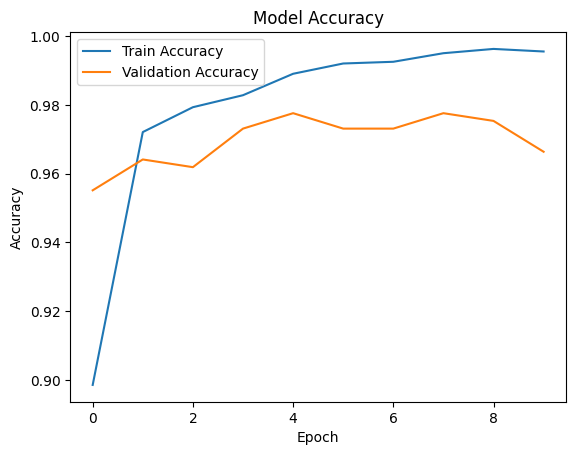

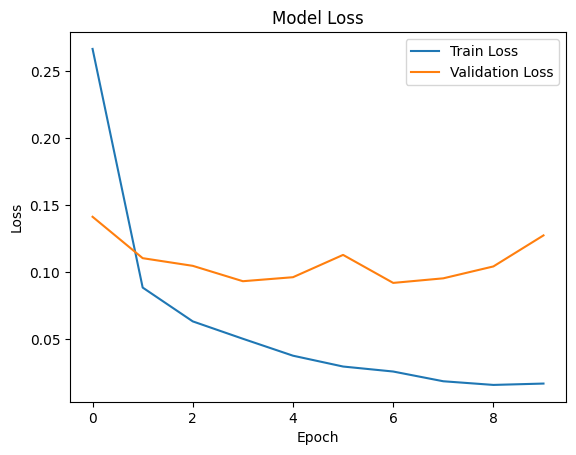

In [42]:
# Графік точності
plt.plot(history_glove.history['accuracy'], label='Train Accuracy')
plt.plot(history_glove.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Графік втрат
plt.plot(history_glove.history['loss'], label='Train Loss')
plt.plot(history_glove.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [43]:
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")
print("Classification Report:\n")
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n")
print(conf_matrix)

35/35 [==============================] - 1s 8ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       954
           1       0.95      0.89      0.92       161

    accuracy                           0.98      1115
   macro avg       0.96      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Confusion Matrix:

[[946   8]
 [ 18 143]]
